# Bisender  Multiple Access Channel Nonlocality and Capacity

This notebook explores the capacity and of nonlocal correlations found for quantum bisender multiple access channels where each sender can use one qubit (or bit) of communication.

In [1]:
from qnet_context import QNetOptimizer as QNopt
from mac_context import *
from pennylane import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

### Linear Inequalities Bounding Bisender MAC

In [2]:
mac_bound_inequalities = [
    (np.array([[0,0,0,0,1,0,1,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,1,0,1,0,0,0,0],[1,1,0,1,0,0,0,0,0]]), 4),
    (np.array([[0,0,0,0,0,1,1,0,0],[1,1,0,1,0,0,0,1,0]]), 5),
    (np.array([[0,0,0,0,1,0,0,0,1],[1,1,0,1,0,1,0,0,0]]), 5),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,1,0,1,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,2,0,1,0,0,0,1,0]]), 7),
    (np.array([[0,0,1,0,1,0,1,0,0],[2,1,0,2,0,1,0,0,0]]), 7),
    (np.array([[0,0,0,0,1,1,1,0,1],[1,1,0,1,0,0,0,1,0]]), 6),
    (np.array([[0,0,0,0,1,1,2,0,0],[2,2,0,1,0,0,0,1,0]]), 8),
    (np.array([[0,0,0,0,2,0,1,0,1],[2,2,0,1,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,1,0,0,0]]), 8),
    (np.array([[0,0,1,0,2,0,0,0,1],[2,1,0,2,0,0,0,1,0]]), 8),
    (np.array([[0,0,1,0,1,0,2,0,0],[2,1,0,0,0,1,0,2,0]]), 8),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,1,0,0,0]]), 10),
    (np.array([[0,0,1,0,2,0,1,0,1],[3,2,0,2,0,0,0,1,0]]), 10),
    (np.array([[0,0,2,0,1,0,2,0,0],[3,1,0,1,0,2,0,2,0]]), 11),
    (np.array([[0,0,2,0,2,0,2,0,0],[3,1,0,1,0,3,0,3,1]]), 14),
    (np.array([[0,0,2,0,3,0,2,0,1],[5,3,0,3,0,1,0,1,0]]), 16),
    (np.array([[0,0,2,1,2,0,5,0,1],[4,2,0,0,0,1,0,4,0]]), 17),
]

### Helper Functions for Rate Region Evaluation

In [3]:
def mac_rate_region(mac_ansatz, inequality, priors_range):
    
    rand_settings = mac_ansatz.rand_scenario_settings()
    
    post_processing_map = np.array([[1,0,0,1],[0,1,1,0]])

    cost = QNopt.linear_probs_cost(mac_ansatz, inequality[0], post_processing_map)

    opt_dict = QNopt.gradient_descent(cost, rand_settings, step_size=0.1, num_steps=100, sample_width=25)
    
    print("max score : ", opt_dict["opt_score"]) 
    print("classical bound : ", inequality[1])
    
    mac_behavior = QNopt.behavior(mac_ansatz, post_processing_map = post_processing_map)
    opt_behavior = mac_behavior(opt_dict["opt_settings"])
    
    rates = []
    priors = []
    for priors_x in priors_range:
        for priors_y in priors_range:
            priors.append((priors_x, priors_y))
            rates.append(bisender_mac_mutual_info(opt_behavior, priors_x, priors_y))
    
    rate_sums = [sum(rate_set) for rate_set in rates]
    max_rate_sum = max(rate_sums)
    max_rate_id = rate_sums.index(max_rate_sum)
    max_rate_tuple = rates[max_rate_id]

    print("rate triple : ", max_rate_tuple)
    print("priors tuple : ", priors[max_rate_id])
    
    print("\nMax Rate Region")
    plot_rate_region(max_rate_tuple)
    
    print("\nUniform Priors Rate Region")
    uniform_rates = bisender_mac_mutual_info(opt_behavior, np.ones(3)/3, np.ones(3)/3)
    plot_rate_region(uniform_rates)

    
scan_range_10 = priors_scan_range(10)
    

### Setup Circuit Ansatzes

Classical MAC, Quantum MAC, and Entanglement-Assisted MAC

In [4]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]
arb_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

entanglement_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

# hack on network outputs to have dim=2
local_arb_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 1, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]

def local_arb_meas_circuit(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings[0:3],wires=[wires[0]])
    qml.templates.subroutines.ArbitraryUnitary(settings[3:6],wires=[wires[1]])

local_meas_node = [
    QNopt.MeasureNode(1,2,[0,1],local_arb_meas_circuit,6)
]

ea_mac_ansatz = QNopt.NetworkAnsatz(entanglement_prep_nodes, local_arb_meas_nodes)
local_mac_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_node)

## Bisender Multiple Access Channel Linear Bounds

### Linear Inequality 0

[[0 0 0 0 1 0 1 0 0]
 [1 1 0 1 0 0 0 0 0]]  <=  4

Classical MAC

iteration :  0 , score :  2.773164181067508
iteration :  25 , score :  3.6595211280909203
iteration :  50 , score :  3.9903586603717005
iteration :  75 , score :  3.9991719100174468
max score :  3.9999084346835856
classical bound :  4


/Users/brian/opt/anaconda3/envs/pennylane-nonlocality-dev/lib/python3.8/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in log2
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


rate triple :  (0.9994200071055208, 0.9994200079278048, 0.9994200079280553)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


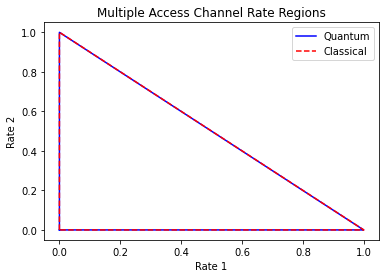


Uniform Priors Rate Region


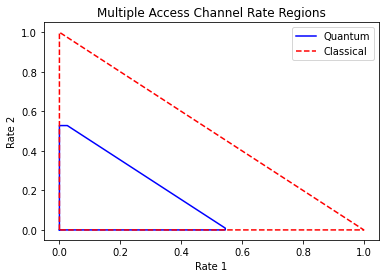


Quantum Communication MAC

iteration :  0 , score :  2.0459921087371997
iteration :  25 , score :  4.378684476785103
iteration :  50 , score :  4.408626439376478
iteration :  75 , score :  4.411328770372642
max score :  4.41253907437178
classical bound :  4
rate triple :  (0.6839358786359133, 2.220446049250313e-16, 0.6839358786359133)
priors tuple :  (tensor([0.4, 0. , 0.6], requires_grad=True), tensor([1., 0., 0.], requires_grad=True))

Max Rate Region


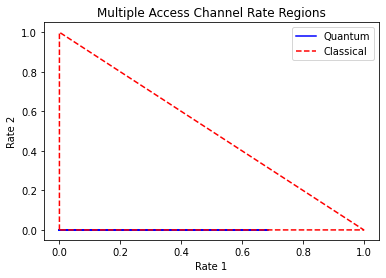


Uniform Priors Rate Region


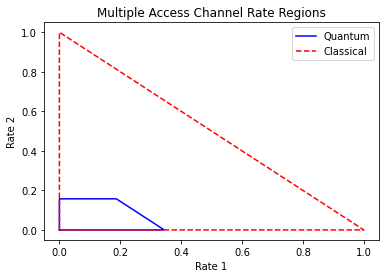


Entanglement-Assisted Classical MAC

iteration :  0 , score :  1.573989834890757
iteration :  25 , score :  4.382444297105592
iteration :  50 , score :  4.40344342184923
iteration :  75 , score :  4.409031539595112
max score :  4.411784041523568
classical bound :  4
rate triple :  (0.6106831511305777, 0.3735542183672753, 0.6358154668542819)
priors tuple :  (tensor([0.4, 0. , 0.6], requires_grad=True), tensor([0.8, 0. , 0.2], requires_grad=True))

Max Rate Region


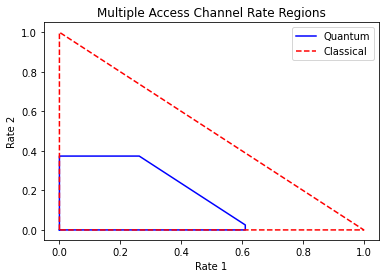


Uniform Priors Rate Region


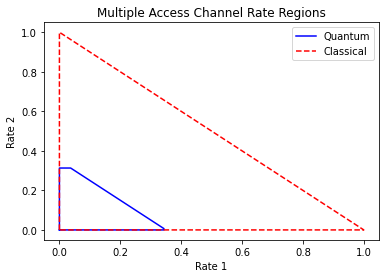

CPU times: user 1min 12s, sys: 726 ms, total: 1min 13s
Wall time: 1min 13s


In [5]:
%%time

inequality = mac_bound_inequalities[0]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 1

[[0 0 1 0 1 0 0 0 0]
 [1 1 0 1 0 0 0 0 0]]  <=  4

Classical MAC

iteration :  0 , score :  2.599921648394594
iteration :  25 , score :  3.995219042231364
iteration :  50 , score :  3.998652135744654
iteration :  75 , score :  3.999413851834455
max score :  3.999726572051349
classical bound :  4
rate triple :  (0.4993863524171065, 0.860758368397085, 0.8607583683972648)
priors tuple :  (tensor([0.8, 0.1, 0.1], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


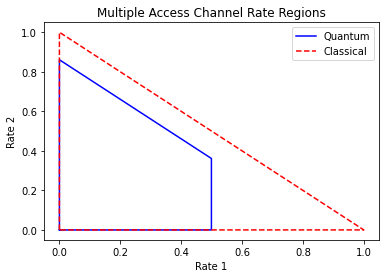


Uniform Priors Rate Region


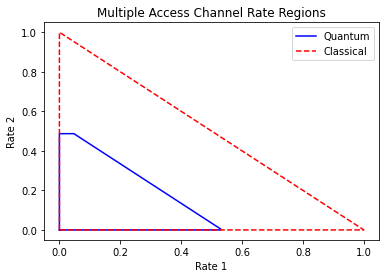


Quantum Communication MAC

iteration :  0 , score :  2.3926898401739676
iteration :  25 , score :  3.9808201520239903
iteration :  50 , score :  3.998249852859276
iteration :  75 , score :  3.9995162482118225
max score :  3.9996693310786475
classical bound :  4
rate triple :  (0.2481790754555835, 0.9039141444988554, 0.9039142427717404)
priors tuple :  (tensor([0. , 0.9, 0.1], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


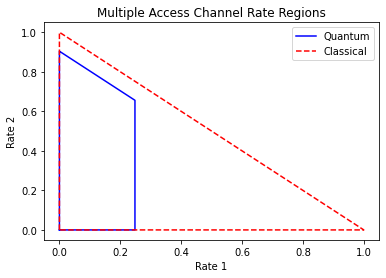


Uniform Priors Rate Region


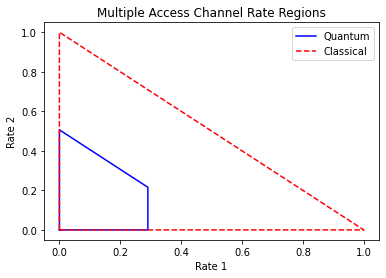


Entanglement-Assisted Classical MAC

iteration :  0 , score :  2.0425854578568847
iteration :  25 , score :  4.118524858921686
iteration :  50 , score :  4.400355039557576
iteration :  75 , score :  4.412730341053939
max score :  4.413890806319041
classical bound :  4
rate triple :  (0.33417362761923375, 0.5913729911350716, 0.6419539289716116)
priors tuple :  (tensor([0. , 0.2, 0.8], requires_grad=True), tensor([0. , 0.6, 0.4], requires_grad=True))

Max Rate Region


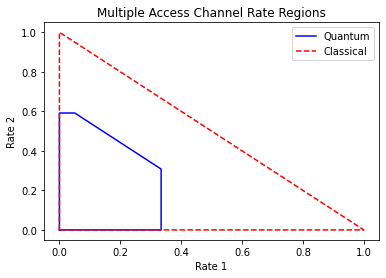


Uniform Priors Rate Region


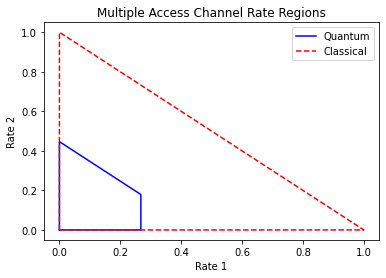

CPU times: user 1min 7s, sys: 508 ms, total: 1min 7s
Wall time: 1min 7s


In [6]:
%%time

inequality = mac_bound_inequalities[1]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 2

[[0 0 0 0 0 1 1 0 0]
 [1 1 0 1 0 0 0 1 0]]  <=  5

Classical MAC

iteration :  0 , score :  3.2587893500836254
iteration :  25 , score :  4.88990073449726
iteration :  50 , score :  4.998906157174264
iteration :  75 , score :  4.999900803985327
max score :  4.999976915858259
classical bound :  5
rate triple :  (0.9998567743309783, 0.9998567741371716, 0.9998567743309796)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


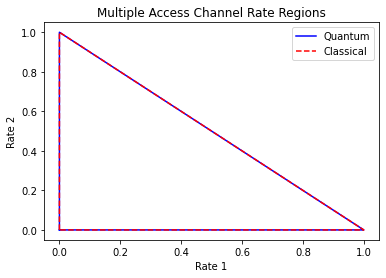


Uniform Priors Rate Region


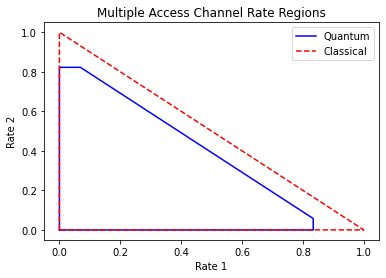


Quantum Communication MAC

iteration :  0 , score :  2.623075930299996
iteration :  25 , score :  5.18990362348733
iteration :  50 , score :  5.305666056126024
iteration :  75 , score :  5.3296462830020825
max score :  5.3351657942666915
classical bound :  5
rate triple :  (0.2326643574934102, 0.8006017539861547, 0.8018997324251393)
priors tuple :  (tensor([0. , 0.9, 0.1], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


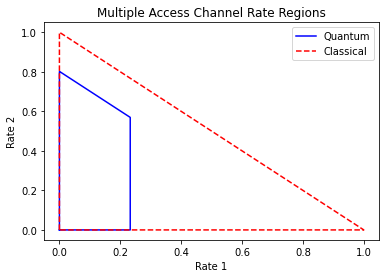


Uniform Priors Rate Region


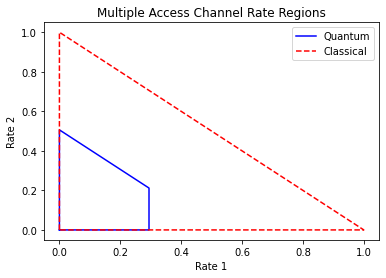


Entanglement-Assisted Classical MAC

iteration :  0 , score :  3.7866066030216197
iteration :  25 , score :  5.114953779972428
iteration :  50 , score :  5.320116977410988
iteration :  75 , score :  5.371134207041548
max score :  5.394730690685063
classical bound :  5
rate triple :  (0.6900072821588066, 0.8346355793617137, 0.8353889317787879)
priors tuple :  (tensor([0. , 0.7, 0.3], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


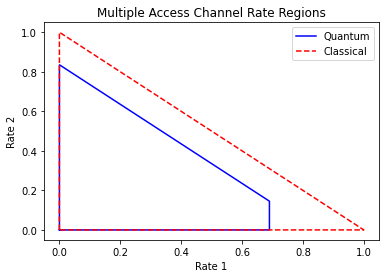


Uniform Priors Rate Region


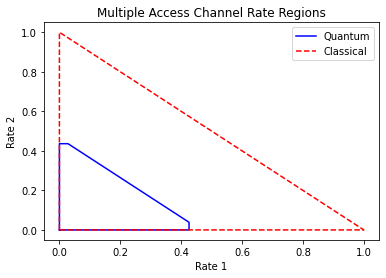

CPU times: user 1min 9s, sys: 600 ms, total: 1min 10s
Wall time: 1min 10s


In [7]:
%%time

inequality = mac_bound_inequalities[2]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 3

[[0 0 0 0 1 0 0 0 1]
 [1 1 0 1 0 1 0 0 0]]  <=  5

Classical MAC

iteration :  0 , score :  2.545488005116269
iteration :  25 , score :  4.037524414842546
iteration :  50 , score :  4.942266921286487
iteration :  75 , score :  4.995461624658922
max score :  4.999585787814824
classical bound :  5
rate triple :  (0.9992340467056287, 0.9992340515560811, 0.9992340515579619)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


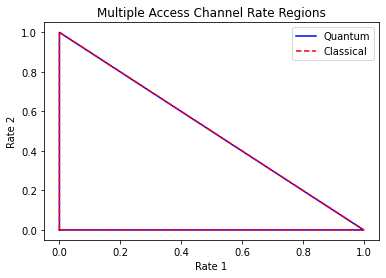


Uniform Priors Rate Region


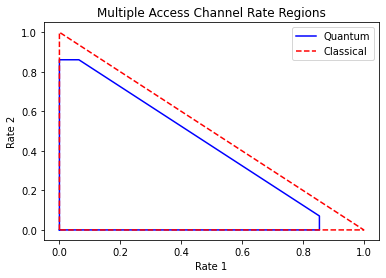


Quantum Communication MAC

iteration :  0 , score :  2.6488016782306856
iteration :  25 , score :  4.89340511379911
iteration :  50 , score :  5.259737778517446
iteration :  75 , score :  5.323717565268096
max score :  5.33131588953572
classical bound :  5
rate triple :  (0.7951210887037592, 0.2361003332772491, 0.796176483864895)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.1, 0.9], requires_grad=True))

Max Rate Region


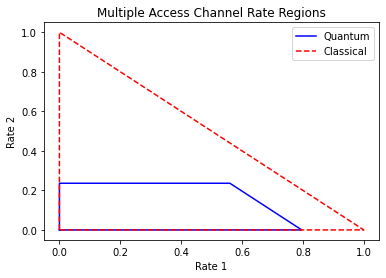


Uniform Priors Rate Region


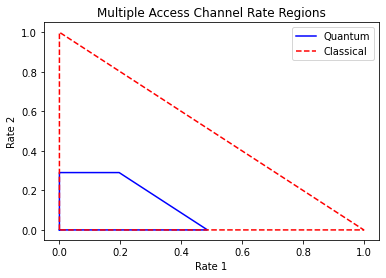


Entanglement-Assisted Classical MAC

iteration :  0 , score :  2.3767304425067435
iteration :  25 , score :  5.123057119234328
iteration :  50 , score :  5.294116211938447
iteration :  75 , score :  5.357747592730457
max score :  5.387287016577051
classical bound :  5
rate triple :  (0.8003471434614444, 0.7962562628699055, 0.8366908514945757)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))

Max Rate Region


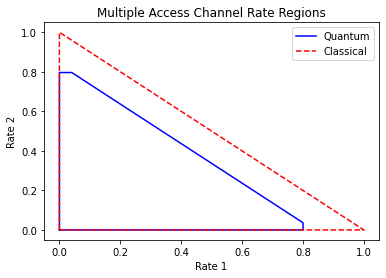


Uniform Priors Rate Region


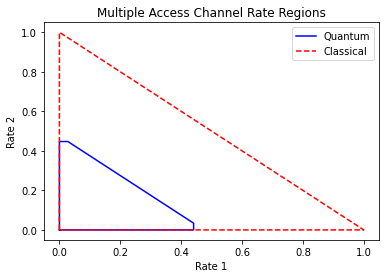

CPU times: user 1min 6s, sys: 388 ms, total: 1min 6s
Wall time: 1min 6s


In [8]:
%%time

inequality = mac_bound_inequalities[3]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 4

[[0 0 1 0 1 0 1 0 0]
 [2 1 0 1 0 1 0 1 0]]  <=  7

Classical MAC

iteration :  0 , score :  4.182411388883173
iteration :  25 , score :  5.94185756715616
iteration :  50 , score :  5.984576937545614
iteration :  75 , score :  5.997152252397612
max score :  6.017437802873126
classical bound :  7
rate triple :  (0.4696076766899382, 2.220446049250313e-16, 0.4696076766899382)
priors tuple :  (tensor([0.6, 0. , 0.4], requires_grad=True), tensor([1., 0., 0.], requires_grad=True))

Max Rate Region


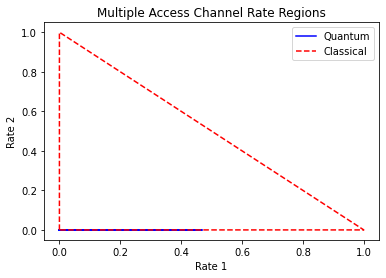


Uniform Priors Rate Region


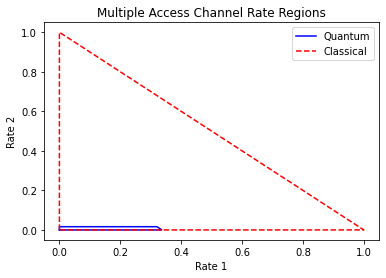


Quantum Communication MAC

iteration :  0 , score :  4.556233000911569
iteration :  25 , score :  6.399672400689441
iteration :  50 , score :  6.592636130489968
iteration :  75 , score :  6.669054184586226
max score :  6.808904587640573
classical bound :  7
rate triple :  (0.7381752811962361, 0.707693697773923, 0.7381757477781168)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.6, 0. , 0.4], requires_grad=True))

Max Rate Region


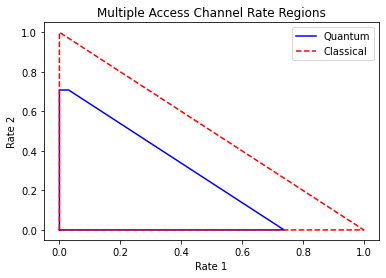


Uniform Priors Rate Region


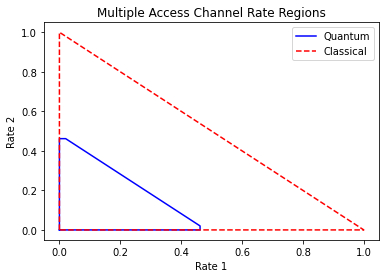


Entanglement-Assisted Classical MAC

iteration :  0 , score :  3.498652945386569
iteration :  25 , score :  7.661104819677395
iteration :  50 , score :  7.768155602945618
iteration :  75 , score :  7.776470122034533
max score :  7.777200723634232
classical bound :  7
rate triple :  (0.503038429065239, 0.586559453803559, 0.6295473300731351)
priors tuple :  (tensor([0. , 0.7, 0.3], requires_grad=True), tensor([0. , 0.6, 0.4], requires_grad=True))

Max Rate Region


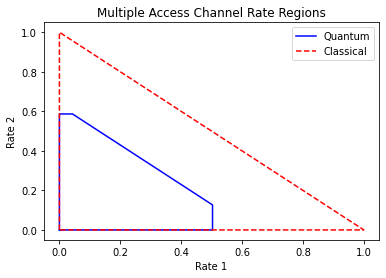


Uniform Priors Rate Region


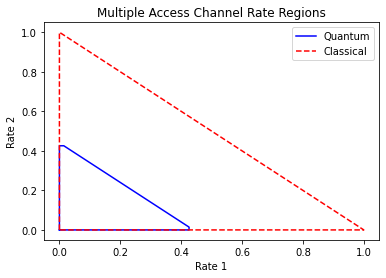

CPU times: user 1min 12s, sys: 710 ms, total: 1min 13s
Wall time: 1min 13s


In [9]:
%%time

inequality = mac_bound_inequalities[4]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 5

[[0 0 1 0 1 0 1 0 0]
 [2 2 0 1 0 0 0 1 0]]  <=  7

Classical MAC

iteration :  0 , score :  4.448050659153885
iteration :  25 , score :  6.769133997116306
iteration :  50 , score :  6.977484073867078
iteration :  75 , score :  6.9972184383648806
max score :  6.999634028562559
classical bound :  7
rate triple :  (0.7478180784241579, 0.8926170751119722, 0.8926170768808834)
priors tuple :  (tensor([0.7, 0. , 0.3], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


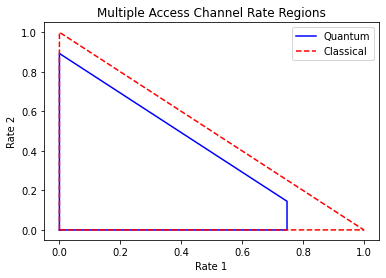


Uniform Priors Rate Region


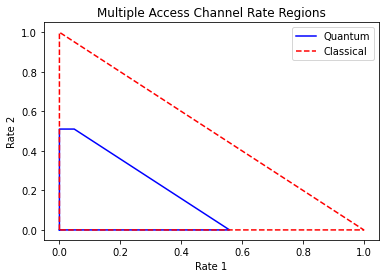


Quantum Communication MAC

iteration :  0 , score :  5.943870745849641
iteration :  25 , score :  7.0073019911407215
iteration :  50 , score :  7.0355985662396465
iteration :  75 , score :  7.117979855639614
max score :  7.234314626661372
classical bound :  7
rate triple :  (0.0, 0.8025417582123415, 0.8025417582123415)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


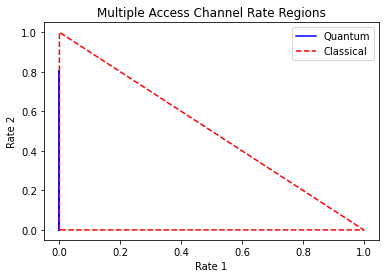


Uniform Priors Rate Region


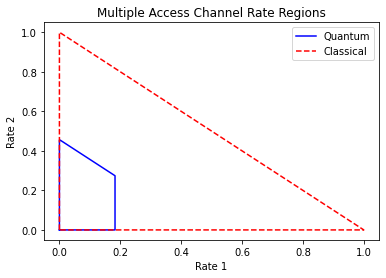


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.55598436829805
iteration :  25 , score :  7.1112894273920615
iteration :  50 , score :  7.72760852460301
iteration :  75 , score :  7.812692366004628
max score :  7.823936110523846
classical bound :  7
rate triple :  (0.10876841020120098, 0.6310504078717489, 0.6418291834983707)
priors tuple :  (tensor([0.9, 0. , 0.1], requires_grad=True), tensor([0.1, 0.3, 0.6], requires_grad=True))

Max Rate Region


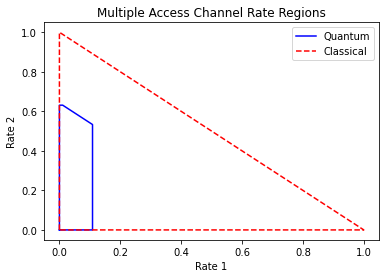


Uniform Priors Rate Region


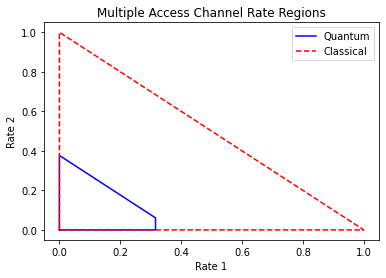

CPU times: user 1min 5s, sys: 325 ms, total: 1min 5s
Wall time: 1min 5s


In [10]:
%%time

inequality = mac_bound_inequalities[5]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 6

[[0 0 1 0 1 0 1 0 0]
 [2 1 0 2 0 1 0 0 0]]  <=  7

Classical MAC

iteration :  0 , score :  4.503749621899937
iteration :  25 , score :  6.779885183509586
iteration :  50 , score :  6.984763651985434
iteration :  75 , score :  6.998466251700042
max score :  6.9998405183994326
classical bound :  7
rate triple :  (0.9998248610711036, 0.9998248609311737, 0.9998248610711093)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


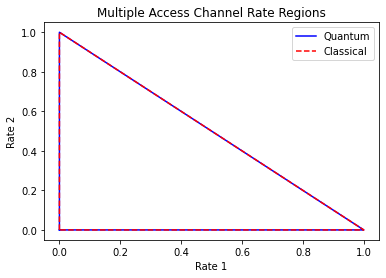


Uniform Priors Rate Region


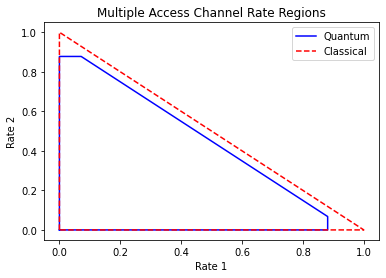


Quantum Communication MAC

iteration :  0 , score :  4.448914612661799
iteration :  25 , score :  6.696420770284675
iteration :  50 , score :  7.0928133177203305
iteration :  75 , score :  7.28346726871201
max score :  7.306379186470677
classical bound :  7
rate triple :  (0.8548092533843714, 0.2638536099885005, 0.8552032800592035)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0. , 0.9, 0.1], requires_grad=True))

Max Rate Region


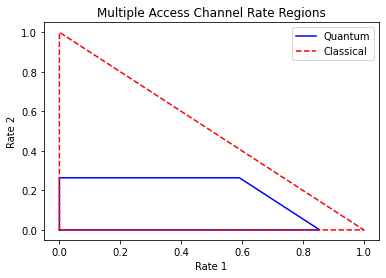


Uniform Priors Rate Region


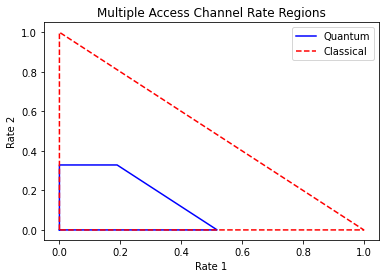


Entanglement-Assisted Classical MAC

iteration :  0 , score :  3.1133910105994267
iteration :  25 , score :  7.791863360960355
iteration :  50 , score :  7.8216286666921855
iteration :  75 , score :  7.826444233526381
max score :  7.827814054315633
classical bound :  7
rate triple :  (0.6308061689454147, 0.13248905633829455, 0.6362549525845904)
priors tuple :  (tensor([0.2, 0.2, 0.6], requires_grad=True), tensor([0.9, 0. , 0.1], requires_grad=True))

Max Rate Region


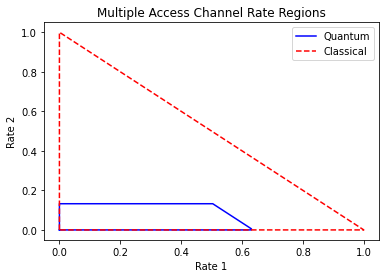


Uniform Priors Rate Region


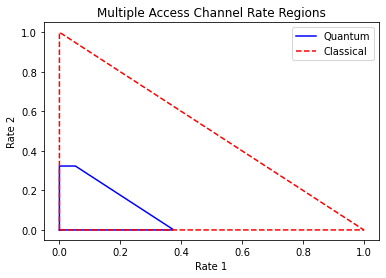

CPU times: user 1min 5s, sys: 317 ms, total: 1min 5s
Wall time: 1min 5s


In [11]:
%%time

inequality = mac_bound_inequalities[6]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 7

[[0 0 0 0 1 1 1 0 1]
 [1 1 0 1 0 0 0 1 0]]  <=  6

Classical MAC

iteration :  0 , score :  3.8337075051607163
iteration :  25 , score :  5.429946752798014
iteration :  50 , score :  5.799449879484596
iteration :  75 , score :  5.946374418674663
max score :  5.980632688508635
classical bound :  6
rate triple :  (0.9953156681035751, -2.220446049250313e-16, 0.9953156681035751)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0., 0., 1.], requires_grad=True))

Max Rate Region


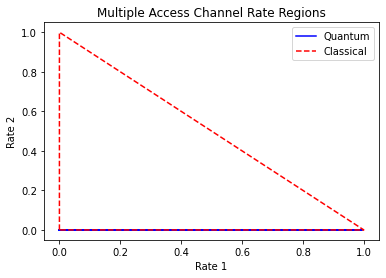


Uniform Priors Rate Region


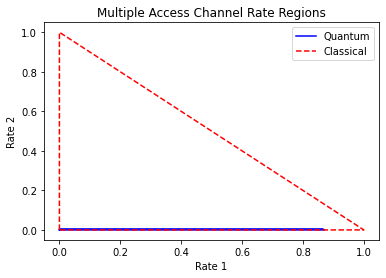


Quantum Communication MAC

iteration :  0 , score :  3.4055096830446283
iteration :  25 , score :  5.8566234677885305
iteration :  50 , score :  6.388564687064684
iteration :  75 , score :  6.4653102000502365
max score :  6.492236020888547
classical bound :  6
rate triple :  (0.45103740279977345, 0.45127669655068026, 0.45129540214958697)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


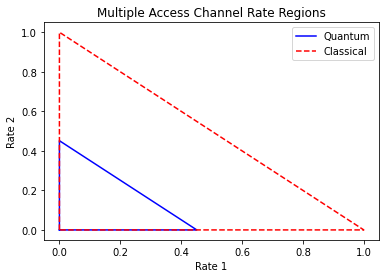


Uniform Priors Rate Region


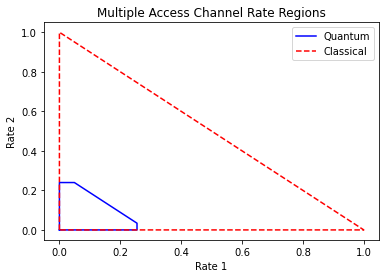


Entanglement-Assisted Classical MAC

iteration :  0 , score :  4.136623315915346
iteration :  25 , score :  6.008951581622477
iteration :  50 , score :  6.099713249858631
iteration :  75 , score :  6.321232098715503
max score :  6.480354070573946
classical bound :  6
rate triple :  (0.37592025983389066, 0.3761242507314422, 0.37645537149324637)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


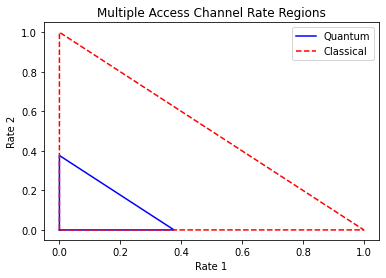


Uniform Priors Rate Region


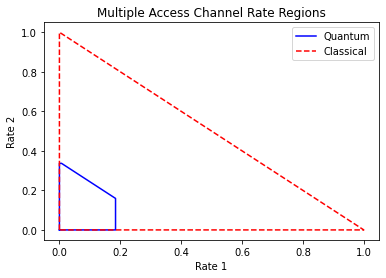

CPU times: user 1min 10s, sys: 485 ms, total: 1min 10s
Wall time: 1min 10s


In [12]:
%%time

inequality = mac_bound_inequalities[7]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 8

[[0 0 0 0 1 1 2 0 0]
 [2 2 0 1 0 0 0 1 0]]  <=  8

Classical MAC

iteration :  0 , score :  2.929263775381623
iteration :  25 , score :  7.760768350867118
iteration :  50 , score :  7.961508183899276
iteration :  75 , score :  7.99063689471439
max score :  7.997079535392564
classical bound :  8
rate triple :  (0.9996921630885744, 0.0, 0.9996921630885744)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0., 1., 0.], requires_grad=True))

Max Rate Region


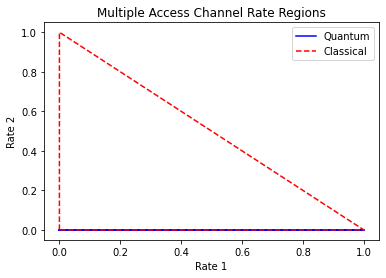


Uniform Priors Rate Region


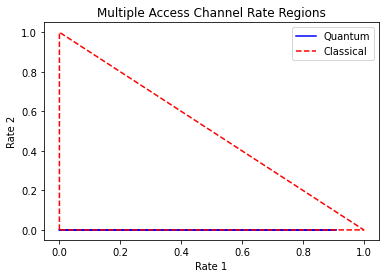


Quantum Communication MAC

iteration :  0 , score :  6.02278120581182
iteration :  25 , score :  8.16686734749152
iteration :  50 , score :  8.449613141203647
iteration :  75 , score :  8.62165215034108
max score :  8.658928071540231
classical bound :  8
rate triple :  (0.49139619197993945, 0.4914143697635698, 0.4914598964173864)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


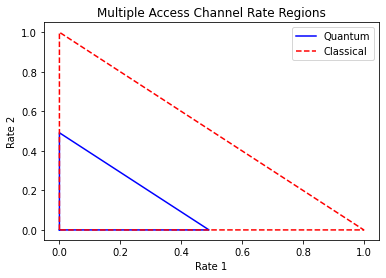


Uniform Priors Rate Region


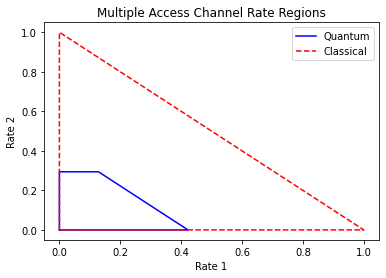


Entanglement-Assisted Classical MAC

iteration :  0 , score :  6.418434566139758
iteration :  25 , score :  7.9400677026621365
iteration :  50 , score :  8.227990302660562
iteration :  75 , score :  8.662738773824886
max score :  8.732733987866471
classical bound :  8
rate triple :  (0.8227911808400563, 0.7786319499126, 0.8229069108646518)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.4, 0. , 0.6], requires_grad=True))

Max Rate Region


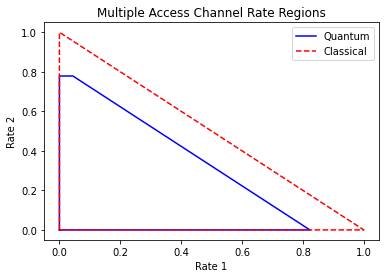


Uniform Priors Rate Region


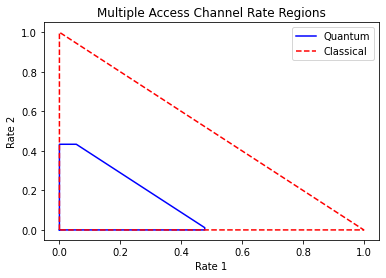

CPU times: user 1min 8s, sys: 364 ms, total: 1min 8s
Wall time: 1min 8s


In [13]:
%%time

inequality = mac_bound_inequalities[8]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 9

[[0 0 0 0 2 0 1 0 1]
 [2 2 0 1 0 1 0 0 0]]  <=  8

Classical MAC

iteration :  0 , score :  4.858780352062022
iteration :  25 , score :  7.82188031216682
iteration :  50 , score :  7.955585466181914
iteration :  75 , score :  7.9817164857878975
max score :  7.991519175183774
classical bound :  8
rate triple :  (0.9972681568119872, -4.440892098500626e-16, 0.9972681568119872)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0., 1., 0.], requires_grad=True))

Max Rate Region


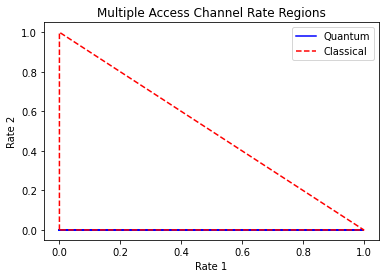


Uniform Priors Rate Region


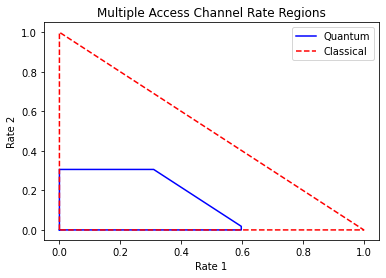


Quantum Communication MAC

iteration :  0 , score :  3.724180196615241
iteration :  25 , score :  7.978443009623031
iteration :  50 , score :  8.412726919148175
iteration :  75 , score :  8.822797950739451
max score :  8.827195449913471
classical bound :  8
rate triple :  (0.6255660207972153, 0.17186041053223322, 0.6256391616009498)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([0. , 0.1, 0.9], requires_grad=True))

Max Rate Region


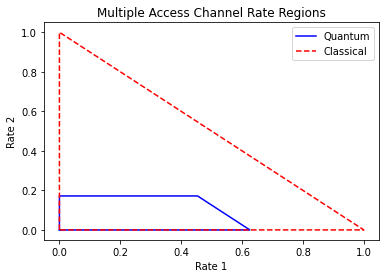


Uniform Priors Rate Region


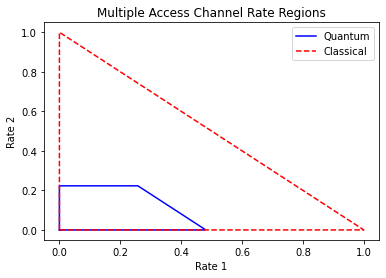


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.294518157638534
iteration :  25 , score :  7.754324150357202
iteration :  50 , score :  8.44721446386245
iteration :  75 , score :  8.890953241751381
max score :  8.952998138927116
classical bound :  8
rate triple :  (0.6849828833162943, 0.4081653070926403, 0.7240359427040655)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.2, 0.8], requires_grad=True))

Max Rate Region


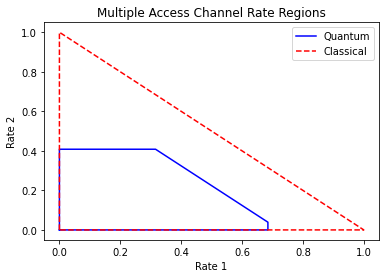


Uniform Priors Rate Region


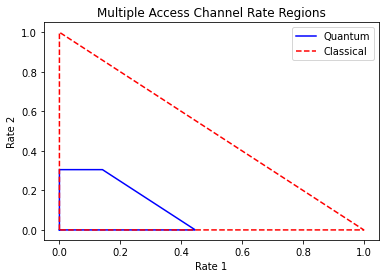

CPU times: user 1min 7s, sys: 400 ms, total: 1min 8s
Wall time: 1min 8s


In [14]:
%%time

inequality = mac_bound_inequalities[9]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 10

[[0 0 1 0 2 0 0 0 1]
 [2 1 0 2 0 1 0 0 0]]  <=  8

Classical MAC

iteration :  0 , score :  3.507114780141335
iteration :  25 , score :  7.819553884024293
iteration :  50 , score :  7.994550687066969
iteration :  75 , score :  7.999793466961579
max score :  7.999991931943467
classical bound :  8
rate triple :  (0.9999298084039445, 0.9999298084426567, 0.9999298084426584)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


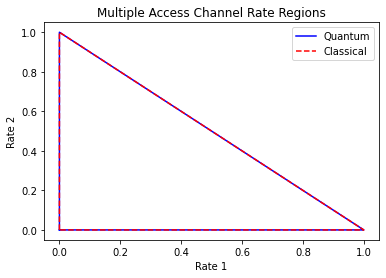


Uniform Priors Rate Region


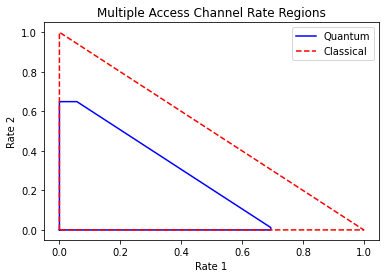


Quantum Communication MAC

iteration :  0 , score :  6.3920601504307015
iteration :  25 , score :  8.373649000069241
iteration :  50 , score :  8.63775456080105
iteration :  75 , score :  8.666119481208474
max score :  8.671597276212376
classical bound :  8
rate triple :  (0.5028171728444661, 0.50281630873108, 0.5028172722941111)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


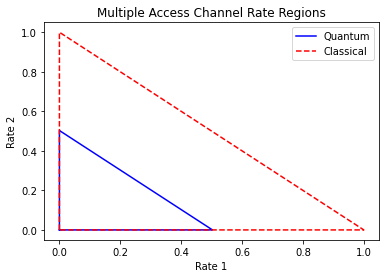


Uniform Priors Rate Region


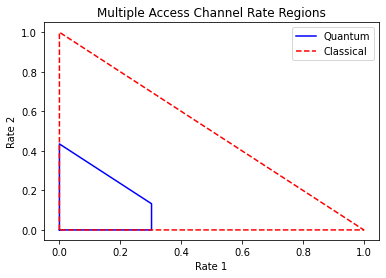


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.208140625662651
iteration :  25 , score :  8.450549028412123
iteration :  50 , score :  8.680835430457746
iteration :  75 , score :  8.72862699189472
max score :  8.739842296050984
classical bound :  8
rate triple :  (0.6772815541296073, 0.720672089949336, 0.7211880382104021)
priors tuple :  (tensor([0. , 0.4, 0.6], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


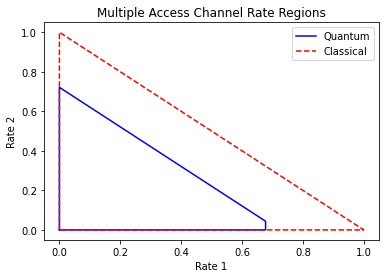


Uniform Priors Rate Region


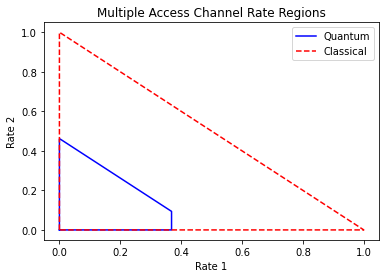

CPU times: user 1min 11s, sys: 653 ms, total: 1min 12s
Wall time: 1min 12s


In [15]:
%%time

inequality = mac_bound_inequalities[10]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 11

[[0 0 1 0 2 0 0 0 1]
 [2 1 0 2 0 0 0 1 0]]  <=  8

Classical MAC

iteration :  0 , score :  5.343805919041859
iteration :  25 , score :  7.756098873534614
iteration :  50 , score :  7.971036279719493
iteration :  75 , score :  7.990701069317127
max score :  7.995096373836787
classical bound :  8
rate triple :  (0.0, 0.9997850033908156, 0.9997850033908156)
priors tuple :  (tensor([1., 0., 0.], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


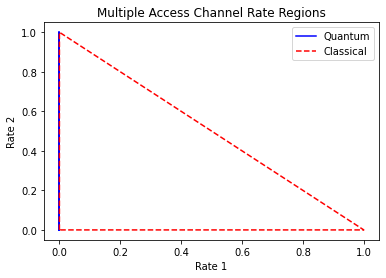


Uniform Priors Rate Region


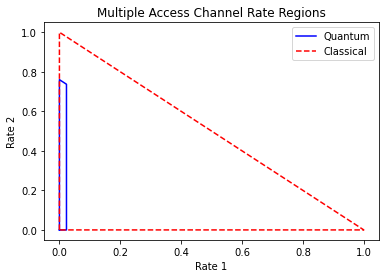


Quantum Communication MAC

iteration :  0 , score :  4.519224399320327
iteration :  25 , score :  8.1000335284992
iteration :  50 , score :  8.399849390696893
iteration :  75 , score :  8.795133594828533
max score :  8.82572624111486
classical bound :  8
rate triple :  (0.17276158348261217, 0.6252993753582494, 0.6253971700487408)
priors tuple :  (tensor([0. , 0.1, 0.9], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))

Max Rate Region


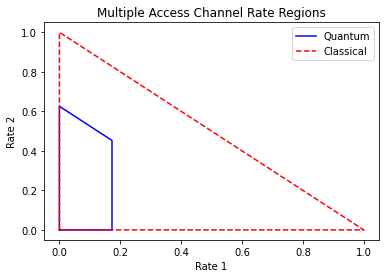


Uniform Priors Rate Region


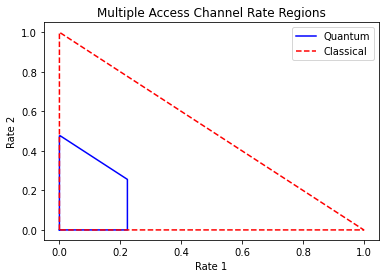


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.0637785365945085
iteration :  25 , score :  7.769550442505417
iteration :  50 , score :  7.954177782925827
iteration :  75 , score :  8.013584250083651
max score :  8.223832606264764
classical bound :  8
rate triple :  (0.6531618952568019, 0.8194465473216703, 0.8194761539997812)
priors tuple :  (tensor([0. , 0.7, 0.3], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


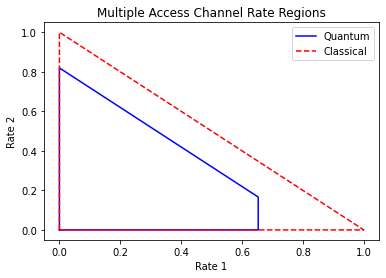


Uniform Priors Rate Region


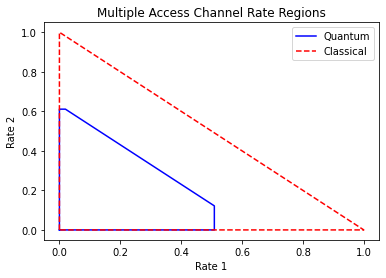

CPU times: user 1min 15s, sys: 829 ms, total: 1min 16s
Wall time: 1min 16s


In [16]:
%%time

inequality = mac_bound_inequalities[11]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 12

[[0 0 1 0 1 0 2 0 0]
 [2 1 0 0 0 1 0 2 0]]  <=  8

Classical MAC

iteration :  0 , score :  5.190443136033492
iteration :  25 , score :  6.8891102981729695
iteration :  50 , score :  7.965570850970046
iteration :  75 , score :  7.998181157546137
max score :  7.999842911492415
classical bound :  8
rate triple :  (0.9999488157078433, 0.9999488157011123, 0.9999488157078451)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


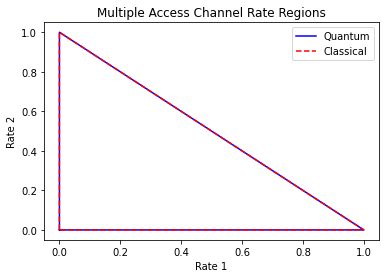


Uniform Priors Rate Region


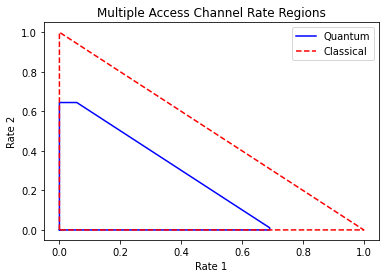


Quantum Communication MAC

iteration :  0 , score :  4.968630655588226
iteration :  25 , score :  8.025557250411827
iteration :  50 , score :  8.146815282177537
iteration :  75 , score :  8.160893167651682
max score :  8.1620848614965
classical bound :  8
rate triple :  (0.8272041914583319, 0.8272043042981636, 0.8272043055032636)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


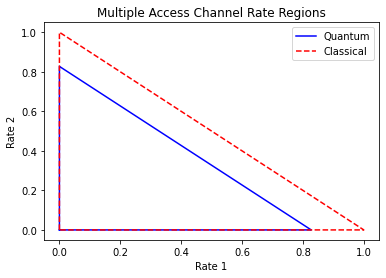


Uniform Priors Rate Region


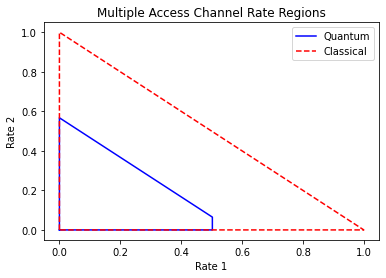


Entanglement-Assisted Classical MAC

iteration :  0 , score :  6.831224741147324
iteration :  25 , score :  8.898185450642933
iteration :  50 , score :  8.95525635858304
iteration :  75 , score :  8.958103858214393
max score :  8.958619226259495
classical bound :  8
rate triple :  (0.6734056910622903, 0.535245487800069, 0.6828816794308339)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.3, 0.7], requires_grad=True))

Max Rate Region


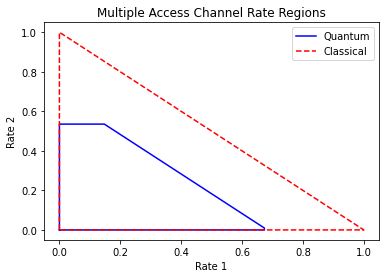


Uniform Priors Rate Region


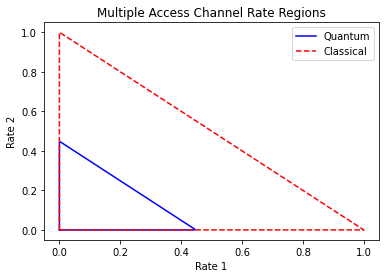

CPU times: user 1min 16s, sys: 864 ms, total: 1min 16s
Wall time: 1min 17s


In [17]:
%%time

inequality = mac_bound_inequalities[12]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 13

[[0 0 1 0 2 0 1 0 1]
 [3 2 0 2 0 1 0 0 0]]  <=  10

Classical MAC

iteration :  0 , score :  5.517099893552219
iteration :  25 , score :  9.147583521042762
iteration :  50 , score :  9.885719036449379
iteration :  75 , score :  9.977032839374033
max score :  9.992691272091342
classical bound :  10
rate triple :  (0.9693666028806245, 0.9694030328569307, 0.9694030329853867)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


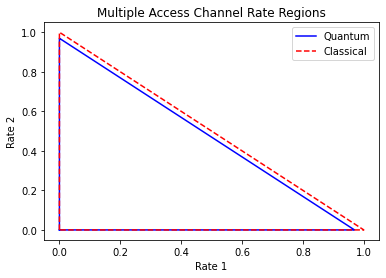


Uniform Priors Rate Region


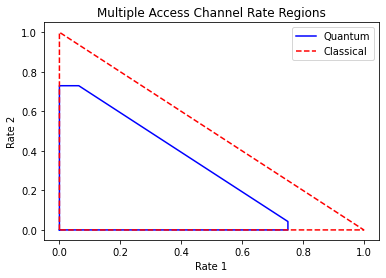


Quantum Communication MAC

iteration :  0 , score :  8.170915771156116
iteration :  25 , score :  10.50732617639582
iteration :  50 , score :  10.693812515120221
iteration :  75 , score :  10.717292077130187
max score :  10.72371428353608
classical bound :  10
rate triple :  (0.740155871543039, 0.20986982663382148, 0.7420258577827099)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.1, 0.9], requires_grad=True))

Max Rate Region


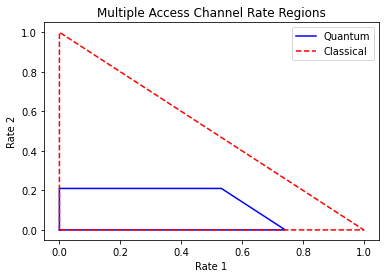


Uniform Priors Rate Region


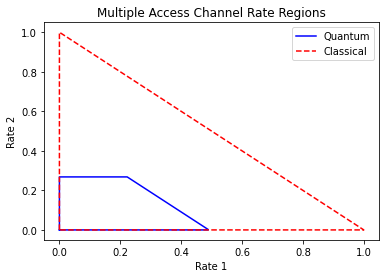


Entanglement-Assisted Classical MAC

iteration :  0 , score :  5.131999332680107
iteration :  25 , score :  11.007166116847003
iteration :  50 , score :  11.144111617515007
iteration :  75 , score :  11.162521522245619
max score :  11.16974417817695
classical bound :  10
rate triple :  (0.5739525007323207, 0.4782277178114134, 0.6029532357785348)
priors tuple :  (tensor([0. , 0.6, 0.4], requires_grad=True), tensor([0. , 0.3, 0.7], requires_grad=True))

Max Rate Region


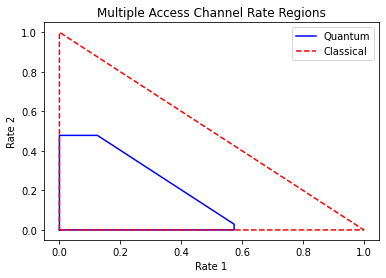


Uniform Priors Rate Region


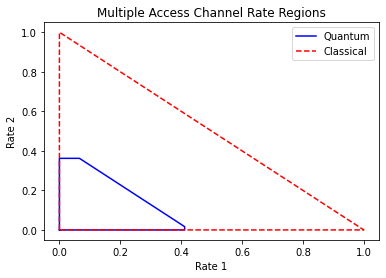

CPU times: user 1min 14s, sys: 779 ms, total: 1min 14s
Wall time: 1min 15s


In [18]:
%%time

inequality = mac_bound_inequalities[13]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 14

[[0 0 1 0 2 0 1 0 1]
 [3 2 0 2 0 0 0 1 0]]  <=  10

Classical MAC

iteration :  0 , score :  6.080530314533741
iteration :  25 , score :  9.959053048496209
iteration :  50 , score :  9.995563042965358
iteration :  75 , score :  9.999049374594117
max score :  9.999724562101079
classical bound :  10
rate triple :  (0.999393656138154, 0.9993936572176492, 0.9993936578086382)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


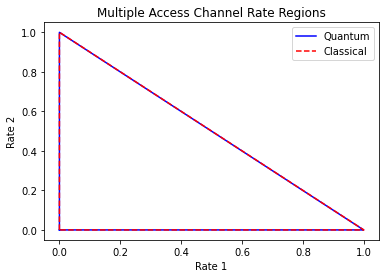


Uniform Priors Rate Region


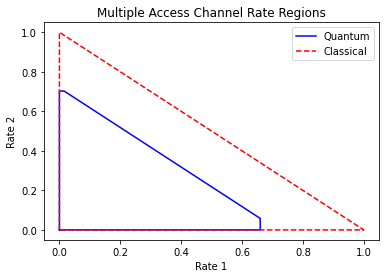


Quantum Communication MAC

iteration :  0 , score :  5.273235920202207
iteration :  25 , score :  10.007850438290943
iteration :  50 , score :  10.134429292251115
iteration :  75 , score :  10.231440180513117
max score :  10.270409862109673
classical bound :  10
rate triple :  (-2.220446049250313e-16, 0.5996208555907818, 0.5996208555907818)
priors tuple :  (tensor([0., 0., 1.], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


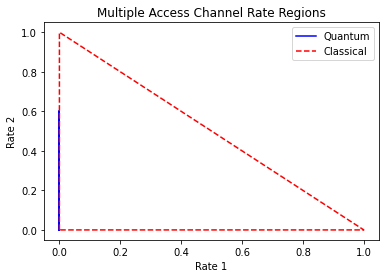


Uniform Priors Rate Region


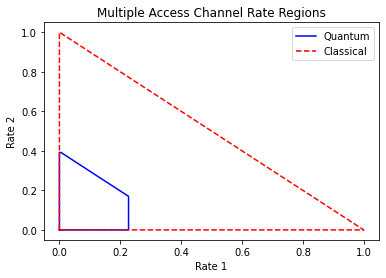


Entanglement-Assisted Classical MAC

iteration :  0 , score :  6.001156606978466
iteration :  25 , score :  10.046993089548106
iteration :  50 , score :  10.556940897999286
iteration :  75 , score :  11.13195367892147
max score :  11.173728613520872
classical bound :  10
rate triple :  (0.47035286881965677, 0.5588689788299122, 0.5956778369235645)
priors tuple :  (tensor([0. , 0.3, 0.7], requires_grad=True), tensor([0. , 0.6, 0.4], requires_grad=True))

Max Rate Region


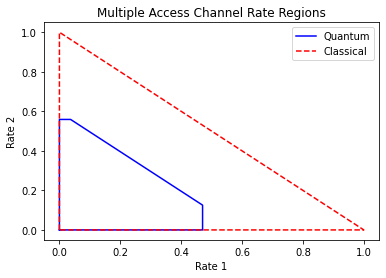


Uniform Priors Rate Region


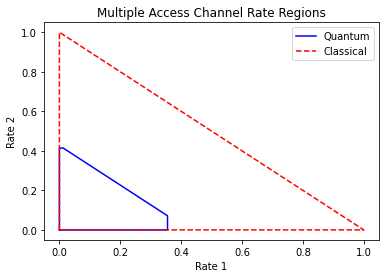

CPU times: user 1min 8s, sys: 433 ms, total: 1min 8s
Wall time: 1min 8s


In [19]:
%%time

inequality = mac_bound_inequalities[14]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 15

[[0 0 2 0 1 0 2 0 0]
 [3 1 0 1 0 2 0 2 0]]  <=  11

Classical MAC

iteration :  0 , score :  7.739394157407619
iteration :  25 , score :  10.964826042246578
iteration :  50 , score :  10.98974902277341
iteration :  75 , score :  10.995511104729282
max score :  10.99777012641207
classical bound :  11
rate triple :  (0.9997669590607732, 0.9997669595025043, 0.9997669595025291)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


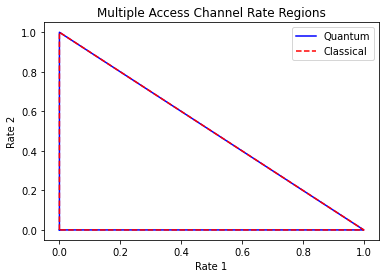


Uniform Priors Rate Region


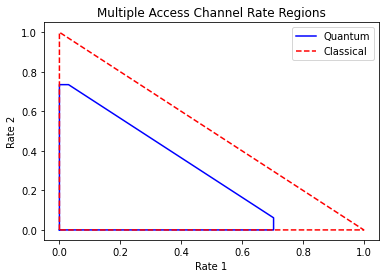


Quantum Communication MAC

iteration :  0 , score :  7.062115622634032
iteration :  25 , score :  11.105977916815167
iteration :  50 , score :  11.130220254525343
iteration :  75 , score :  11.13747120260769
max score :  11.139575470447733
classical bound :  11
rate triple :  (0.8334076991413686, 0.8656156954287755, 0.8656306181328959)
priors tuple :  (tensor([0.6, 0. , 0.4], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


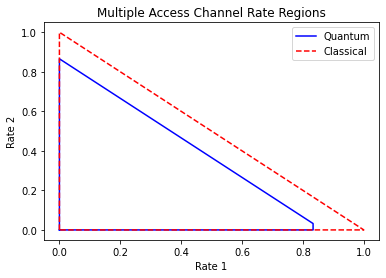


Uniform Priors Rate Region


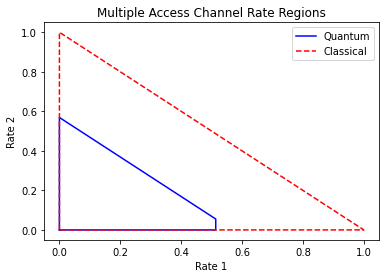


Entanglement-Assisted Classical MAC

iteration :  0 , score :  8.057734212397898
iteration :  25 , score :  12.22345297592216
iteration :  50 , score :  12.27399655010381
iteration :  75 , score :  12.275739774891237
max score :  12.275904512969426
classical bound :  11
rate triple :  (0.5711360302959307, 0.5718425337459441, 0.7116133656325832)
priors tuple :  (tensor([0. , 0.7, 0.3], requires_grad=True), tensor([0. , 0.7, 0.3], requires_grad=True))

Max Rate Region


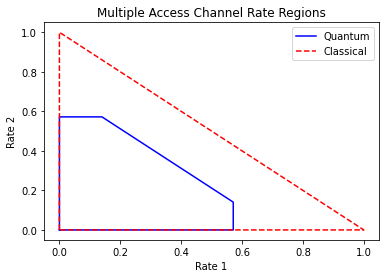


Uniform Priors Rate Region


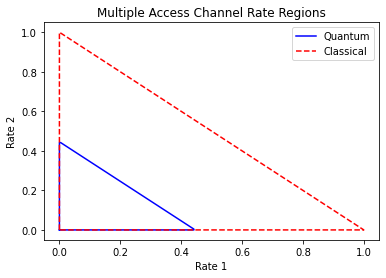

CPU times: user 1min 12s, sys: 510 ms, total: 1min 13s
Wall time: 1min 13s


In [20]:
%%time

inequality = mac_bound_inequalities[15]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality  16

[[0 0 2 0 2 0 2 0 0]
 [3 1 0 1 0 3 0 3 1]]  <=  14

Classical MAC

iteration :  0 , score :  6.6454884194049315
iteration :  25 , score :  13.511499465050242
iteration :  50 , score :  13.999134593634851
iteration :  75 , score :  13.999946714657106
max score :  13.999996807671893
classical bound :  14
rate triple :  (0.999999302245401, 0.999999302245401, 0.9999993022454023)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


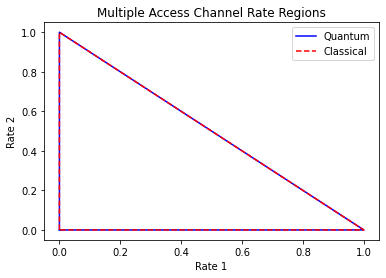


Uniform Priors Rate Region


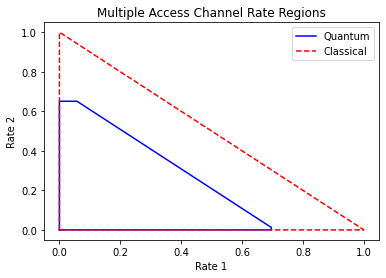


Quantum Communication MAC

iteration :  0 , score :  10.638464880267664
iteration :  25 , score :  13.976566556973124
iteration :  50 , score :  14.022378046481698
iteration :  75 , score :  14.033031040704007
max score :  14.040093370847416
classical bound :  14
rate triple :  (0.9450434118537037, 0.94504727775423, 0.9450486569236354)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


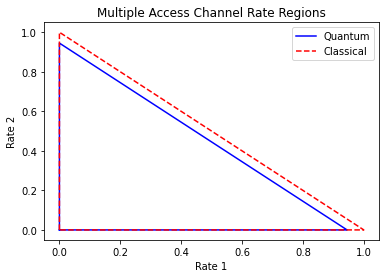


Uniform Priors Rate Region


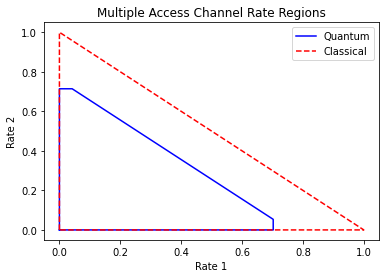


Entanglement-Assisted Classical MAC

iteration :  0 , score :  12.078729638183859
iteration :  25 , score :  15.509428293627657
iteration :  50 , score :  15.537653185894108
iteration :  75 , score :  15.538328515274447
max score :  15.538347790691375
classical bound :  14
rate triple :  (0.5078131007215783, 0.4216648567833423, 0.5685686177272022)
priors tuple :  (tensor([0.6, 0. , 0.4], requires_grad=True), tensor([0.7, 0. , 0.3], requires_grad=True))

Max Rate Region


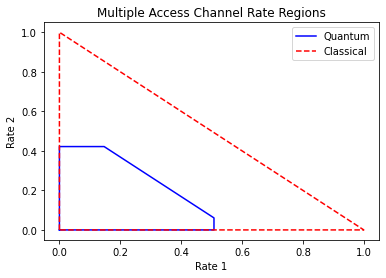


Uniform Priors Rate Region


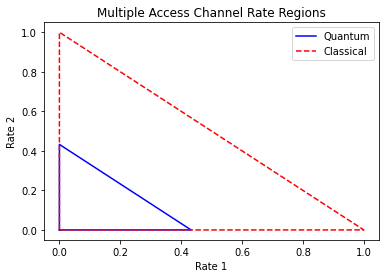

CPU times: user 1min 14s, sys: 550 ms, total: 1min 15s
Wall time: 1min 15s


In [21]:
%%time

inequality = mac_bound_inequalities[16]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 17

[[0 0 2 0 3 0 2 0 1]
 [5 3 0 3 0 1 0 1 0]]  <=  16

Classical MAC

iteration :  0 , score :  11.276719830342742
iteration :  25 , score :  15.808199983033449
iteration :  50 , score :  15.982206184883273
iteration :  75 , score :  15.998179839983225
max score :  15.999817756727174
classical bound :  16
rate triple :  (0.9987678968360831, 0.9987679190568328, 0.998767919056835)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


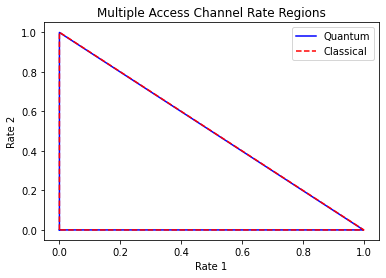


Uniform Priors Rate Region


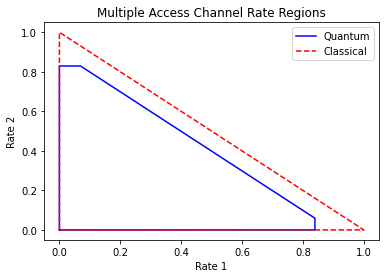


Quantum Communication MAC

iteration :  0 , score :  7.813611907148183
iteration :  25 , score :  16.170277220944456
iteration :  50 , score :  16.76936273806716
iteration :  75 , score :  16.845414142752812
max score :  16.846700192201787
classical bound :  16
rate triple :  (0.6821114651611002, 0.5422512362169214, 0.6822936906347956)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.3, 0.7], requires_grad=True))

Max Rate Region


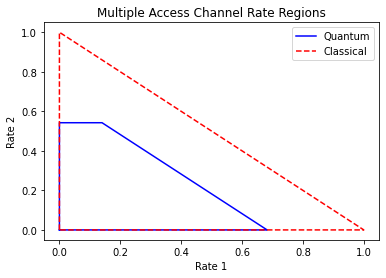


Uniform Priors Rate Region


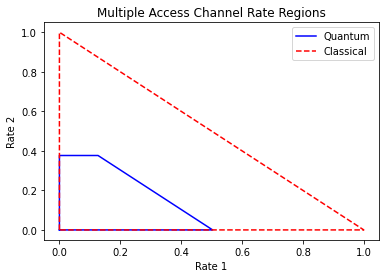


Entanglement-Assisted Classical MAC

iteration :  0 , score :  10.737765090058673
iteration :  25 , score :  16.94369959988898
iteration :  50 , score :  17.762602353324205
iteration :  75 , score :  17.919805094229847
max score :  17.952157564759503
classical bound :  16
rate triple :  (0.4544745749730481, 0.45406747299079786, 0.45447625002027614)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


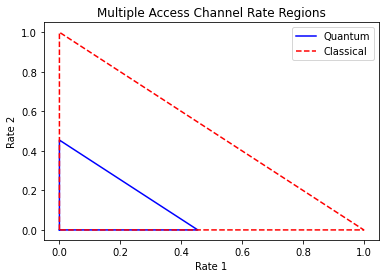


Uniform Priors Rate Region


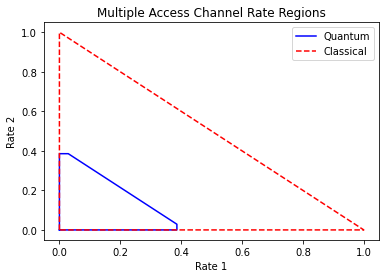

CPU times: user 1min 9s, sys: 441 ms, total: 1min 10s
Wall time: 1min 10s


In [22]:
%%time

inequality = mac_bound_inequalities[17]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)

### Linear Inequality 18

[[0 0 2 1 2 0 5 0 1]
 [4 2 0 0 0 1 0 4 0]]  <=  17

Classical MAC

iteration :  0 , score :  10.471201965335533
iteration :  25 , score :  16.994848927001293
iteration :  50 , score :  16.999832158909452
iteration :  75 , score :  16.999993930870243
max score :  16.999999777478198
classical bound :  17
rate triple :  (0.9999998520979214, 0.999999852097921, 0.9999998520979236)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


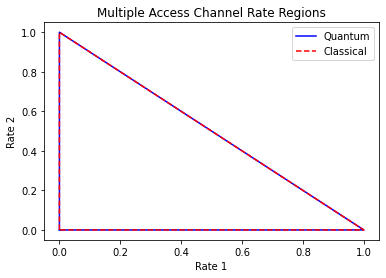


Uniform Priors Rate Region


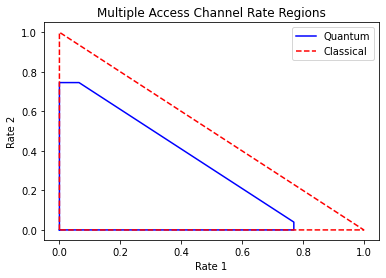


Quantum Communication MAC

iteration :  0 , score :  13.196800547936718
iteration :  25 , score :  17.0844976191952
iteration :  50 , score :  17.1166982458258
iteration :  75 , score :  17.123792854693402
max score :  17.12680934404907
classical bound :  17
rate triple :  (0.7197916246883493, 0.7650216866732862, 0.7672245920307974)
priors tuple :  (tensor([0.4, 0. , 0.6], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


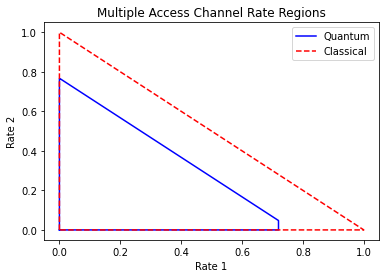


Uniform Priors Rate Region


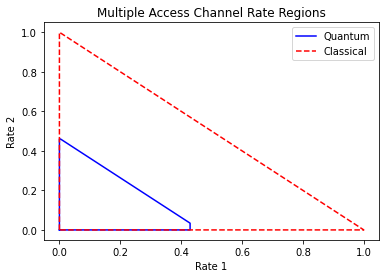


Entanglement-Assisted Classical MAC

iteration :  0 , score :  10.88126303690368
iteration :  25 , score :  17.203655334263715
iteration :  50 , score :  19.04001707962417
iteration :  75 , score :  19.0619911420946
max score :  19.06233619273993
classical bound :  17
rate triple :  (0.5109181316360614, 0.7523711817071481, 0.7878173961494213)
priors tuple :  (tensor([0.2, 0.8, 0. ], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))

Max Rate Region


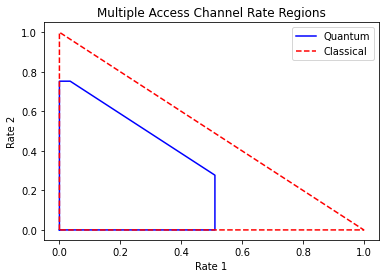


Uniform Priors Rate Region


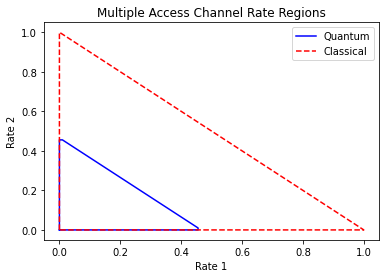

CPU times: user 1min 7s, sys: 566 ms, total: 1min 8s
Wall time: 1min 8s


In [23]:
%%time

inequality = mac_bound_inequalities[18]

print(inequality[0], " <= ", inequality[1])

print("\nClassical MAC\n")
mac_rate_region(local_mac_ansatz, inequality, scan_range_10)

print("\nQuantum Communication MAC\n")
mac_rate_region(arb_mac_ansatz, inequality, scan_range_10)

print("\nEntanglement-Assisted Classical MAC\n")
mac_rate_region(ea_mac_ansatz, inequality, scan_range_10)